In [162]:
'''
Læs Gandhi + Houd instruments november 2020 (Behandling af instrumentvariable). Ellers gå med normale BLP instrumenter

Næste gang:
'''



'\nLæs Gandhi + Houd instruments november 2020 (Behandling af instrumentvariable). Ellers gå med normale BLP instrumenter\n\nNæste gang:\n'

In [163]:
import statsmodels.api as sm
import numpy as np
from scipy.optimize import minimize
from tabulate import tabulate
from numpy import linalg as la
import time
import pandas as pd
import mestim as M
from discrete_choice import * 
import matplotlib.pyplot as plt
import LinearModelsWeek3_post as lm

import logit_func as lf

from numpy import random
from scipy.stats import genextreme


## Data

In [164]:
df_overview = pd.read_csv('Overview.csv')
df_overview.sort_values(by=['Count'], ascending=True, inplace=True) 
df_overview.tail(5)
print(df_overview.columns)

df_overview = pd.read_csv('Overview.csv')
df_overview = df_overview.rename(columns={'Fast charge (min)': 'ChargeTime'})
unique_types = df_overview['Type'].unique()
for i in unique_types:
    df_overview[i] = np.where(df_overview['Type'] == i, 1, 0)


unique_Country = df_overview['Country'].unique()

unique_segments = df_overview['Segment'].unique()
for i in unique_segments:
    df_overview[i] = np.where(df_overview['Segment'] == i, 1, 0)
print(f'segments : {unique_segments} \n Countrys : {unique_Country} \n types : {unique_types}')


#Europa, Kina, USA, Andet
df_overview['Europe'] = np.where((df_overview['Country'] != 'US') & (df_overview['Country'] != 'CH') & (df_overview['Country'] != 'JP') & (df_overview['Country'] != 'KR'), 1, 0)
df_overview['China'] = np.where(df_overview['Country'] == 'CH', 1, 0)
df_overview['USA'] = np.where(df_overview['Country'] == 'US', 1, 0)
df_overview['Other'] = np.where((df_overview['Europe'] != 1) & (df_overview['China'] != 1) & (df_overview['USA'] != 1), 1, 0)

df_overview.head(5)
#df_overview[df_overview['Manufacturer'] == 'Nissan']


Index(['ID', 'Manufacturer', 'Model', 'Range', 'Price', 'HP',
       'Fast charge (min)', 'Type', 'Segment', 'Country', 'Count', 'Share',
       'Percentage'],
      dtype='object')
segments : ['C' 'F' 'E' 'B' 'D' 'M' 'A' 'J'] 
 Countrys : ['CH' 'DE' 'FR' 'SP' 'RO' 'IT' 'DK' 'US' 'JP' 'KR' 'GB' 'SE' 'CZ'] 
 types : ['SUV' 'Sedan' 'Hatchback' 'MPV' 'Stationcar' 'Cabriolet' 'Liftback']


,ID,Manufacturer,Model,Range,Price,HP,ChargeTime,Type,Segment,Country,...,E,B,D,M,A,J,Europe,China,USA,Other
0,1,Aiways,U5,400,3.308258e+05,201,34,SUV,C,CH,...,0,0,0,0,0,0,0,1,0,0
1,2,Aiways,U6,405,3.757100e+05,214,34,SUV,C,CH,...,0,0,0,0,0,0,0,1,0,0
2,3,Audi,e-tron,375,7.149530e+05,402,17,SUV,F,DE,...,0,0,0,0,0,0,1,0,0,0
3,4,Audi,e-tron GT,472,1.081416e+06,522,17,Sedan,F,DE,...,0,0,0,0,0,0,1,0,0,0
4,5,Audi,Q4 e-tron,496,4.547246e+05,281,28,SUV,C,DE,...,0,0,0,0,0,0,1,0,0,0


In [165]:
df_dataset = pd.read_csv('Dataset.csv')
df_dataset = df_dataset.rename(columns={'Fast charge (min)': 'ChargeTime'})
unique_types = df_dataset['Type'].unique()
#print(df_dataset.columns)
for i in unique_types:
    df_dataset[i] = np.where(df_dataset['Type'] == i, 1, 0)


years = df_dataset['year'].unique()

unique_Country = df_dataset['Country'].unique()

unique_segments = df_dataset['Segment'].unique()
for i in unique_segments:
    df_dataset[i] = np.where(df_dataset['Segment'] == i, 1, 0)
#print(f'segments : {unique_segments} \n Countrys : {unique_Country} \n types : {unique_types}')


#Europa, Kina, USA, Andet
df_dataset['Europe'] = np.where((df_dataset['Country'] != 'US') & (df_dataset['Country'] != 'CH') & (df_dataset['Country'] != 'JP') & (df_dataset['Country'] != 'KR'), 1, 0)
df_dataset['China'] = np.where(df_dataset['Country'] == 'CH', 1, 0)
df_dataset['USA'] = np.where(df_dataset['Country'] == 'US', 1, 0)
df_dataset['Other'] = np.where((df_dataset['Europe'] != 1) & (df_dataset['China'] != 1) & (df_dataset['USA'] != 1), 1, 0)
print(df_dataset.head(1))


df_dataset_ms0 = df_dataset[df_dataset['Market share'] != 0]
df_dataset_ms0.sort_values(by=['Market share'], ascending=False, inplace=True)
#print(df_dataset_ms0.sample(1))

df_dataset_year_ms0 = {}
for year in years:
    df_dataset_year_ms0[year] = df_dataset_ms0[df_dataset_ms0['year'] == year]




   ID  year  Market share Manufacturer Model  Range  Price   HP  ChargeTime  \
0   1  2013           0.0       Aiways    U5    400    0.0  201          34   

  Type  ...  E  B  D  M  A  J  Europe  China  USA  Other  
0  SUV  ...  0  0  0  0  0  0       0      1    0      0  

[1 rows x 31 columns]


/var/folders/ys/szn3cjzn7zg_mdp21slh2_hr0000gn/T/ipykernel_68791/3974771862.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset_ms0.sort_values(by=['Market share'], ascending=False, inplace=True)


In [166]:
df_dataset.head(11)
#df.info()

,ID,year,Market share,Manufacturer,Model,Range,Price,HP,ChargeTime,Type,...,E,B,D,M,A,J,Europe,China,USA,Other
0,1,2013,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
1,1,2014,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
2,1,2015,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
3,1,2016,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
4,1,2017,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
5,1,2018,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
6,1,2019,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
7,1,2020,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
8,1,2021,0.010319,Aiways,U5,400,284622.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
9,1,2022,0.005938,Aiways,U5,400,313682.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0


## Grafer

In [167]:
Country_shares = {
    'Europe': [],
    'China': [],
    'USA': [],
    'Other': []
}
#& (df_dataset['Market share'] != 0)
for Country in Country_shares.keys():
    for year in years:
        Country_df = df_dataset[(df_dataset[Country] == 1) & (df_dataset['year'] == year)]
        if not Country_df.empty:
            Country_shares[Country].append(Country_df['Market share'].sum())
#print(Country_shares)




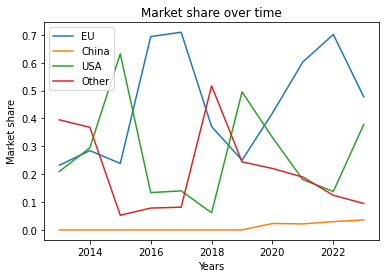

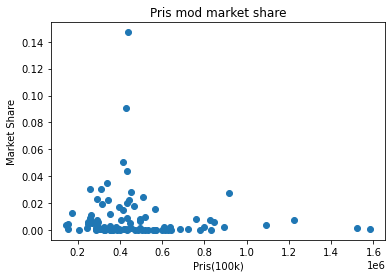

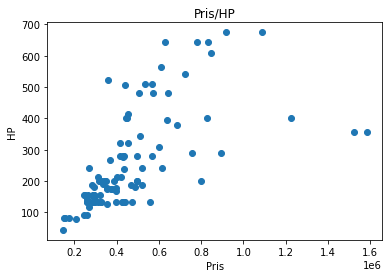

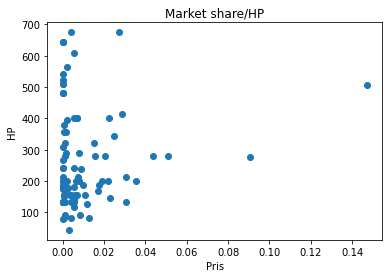

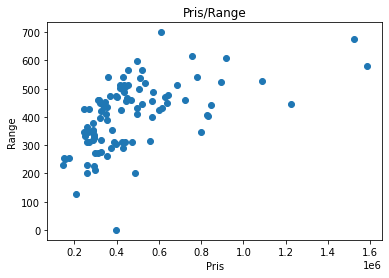

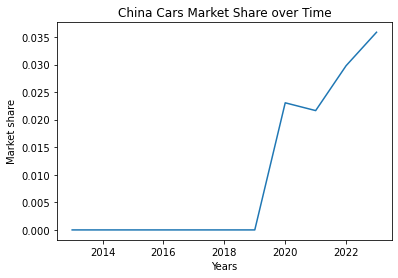

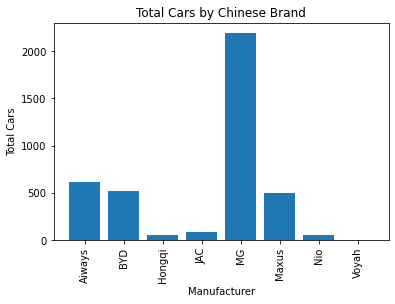

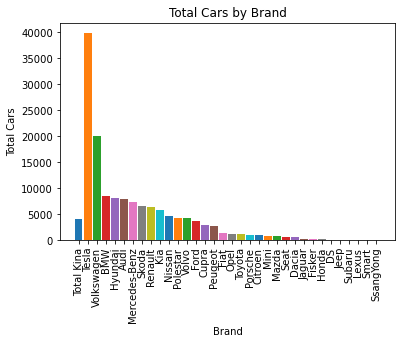

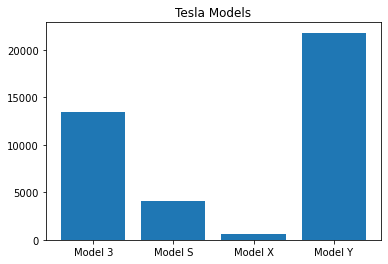

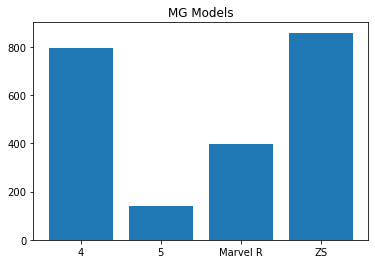

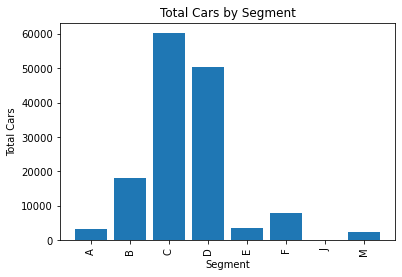

In [168]:
'''
Done
Hvem har størst market share? 
Pris mod market share
Pris/HP
Pris/Range
Hvordan ser det ud for kinesere isoleret?
Kinesere vs resten

Yet to come
Størst udvikling i market share?
'''

#Market share over time
#plt.figure(figsize=(12, 6))
for Country in Country_shares.keys():
    plt.plot(years, Country_shares[Country])
plt.legend(['EU', 'China', 'USA', 'Other'])
plt.xlabel('Years')
plt.ylabel('Market share')
plt.title('Market share over time')
plt.show()

#Pris mod market share
# x = pris, y = Count
#plt.scatter(x,y)
#Kun for de 5 med højest Count
mængde = 100
# Pris/Market Share
plt.scatter(df_overview.Price[len(df_overview)-mængde:], df_overview.Share[len(df_overview)-mængde:])
plt.title('Pris mod market share')
plt.xlabel('Pris(100k)')
plt.ylabel('Market Share')
plt.show()

# Pris/HP
plt.scatter(df_overview.Price[len(df_overview)-mængde:], df_overview.HP[len(df_overview)-mængde:])
plt.title('Pris/HP')
plt.xlabel('Pris')
plt.ylabel('HP')
plt.show()

# Market share/HP
plt.scatter(df_overview.Share[len(df_overview)-mængde:], df_overview.HP[len(df_overview)-mængde:])
plt.title('Market share/HP')
plt.xlabel('Pris')
plt.ylabel('HP')
plt.show()

#Pris/Range
plt.scatter(df_overview.Price[len(df_overview)-mængde:], df_overview.Range[len(df_overview)-mængde:])
plt.title('Pris/Range')
plt.xlabel('Pris')
plt.ylabel('Range')
plt.show()

#Market share over time
plt.plot(years, Country_shares['China'])
plt.xlabel('Years')
plt.ylabel('Market share')
plt.title('China Cars Market Share over Time')
plt.show()

#Total Cars by Chinese Brand
df_china = df_overview[df_overview['China'] == 1]
brand_totals = df_china.groupby('Manufacturer')['Count'].sum()

plt.bar(brand_totals.index, brand_totals.values)
plt.title('Total Cars by Chinese Brand')
plt.xlabel('Manufacturer')
plt.ylabel('Total Cars')
plt.xticks(rotation=90)
plt.show()

#Kinesere by brands
df_china = df_overview[df_overview['China'] == 1]

total_kina = df_china['Count'].sum() #Alle kinesere (samlet)
plt.bar('Total Kina', total_kina)
plt.title('Total Cars by Chinese Brands')


#Alle ikke CH-brands mod total CH. 
df_not_china = df_overview[df_overview['China'] == 0]
not_china_totals = df_not_china.groupby('Manufacturer')['Count'].sum() #Alle ikke kinesere(unikke)
sorted_not_china_totals = not_china_totals.sort_values(ascending=False)

for i, (brand, total) in enumerate(sorted_not_china_totals.items()):
    plt.bar(brand, total, label=brand)

plt.title('Total Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Total Cars')
plt.xticks(rotation=90)
plt.show()

#Tesla models (Største i EU)
df_tesla = df_overview[df_overview['Manufacturer'] == 'Tesla']
df_tesla = df_tesla.groupby('Model')['Count'].sum()
plt.bar(df_tesla.index, df_tesla.values)
plt.title('Tesla Models')
plt.show()

#MG (største kinesiske mærke i DK)
df_mg = df_overview[df_overview['Manufacturer'] == 'MG']
df_mg = df_mg.groupby('Model')['Count'].sum()
plt.bar(df_mg.index, df_mg.values)
plt.title('MG Models')
plt.show()

#Cars by segment
segment_totals = df_overview.groupby('Segment')['Count'].sum()
plt.bar(segment_totals.index, segment_totals.values)
plt.title('Total Cars by Segment')
plt.xlabel('Segment')
plt.ylabel('Total Cars')
plt.xticks(rotation=90)
plt.show()




# Estimering

In [169]:
label_y = 'Market share'
label_x = ['Range', 'Price', 'HP', 'ChargeTime', 'China']
data_scaled = df_dataset
data_scaled['Range'] = data_scaled['Range'] / 100
data_scaled['Price'] = data_scaled['Price'] / 100000
data_scaled['HP'] = data_scaled['HP'] / 100
data_scaled['ChargeTime'] = data_scaled['ChargeTime'] / 100

## Standard OLS

In [170]:
#Bruger data hvor ms = 0 er inkluderet
data = df_dataset
N = data['ID'].unique().size
N
#print("market share value :", df['Market share'].size)
T = data['year'].unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {data.shape[0]}, {N*T}')

Data has N=110 and T=11 data is = 1210, 1210


In [171]:
#Bruger data hvor ms = 0 er inkluderet
N
y = df_dataset['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Range = df_dataset['Range'].values.reshape((N*T,1)) #1
Price = df_dataset['Price'].values.reshape((N*T,1)) #2
HP = df_dataset['HP'].values.reshape((N*T,1)) #3
ChargeTime = df_dataset['ChargeTime'].values.reshape((N*T,1))  #4
China = df_dataset['China'].values.reshape((N*T,1)) #5

X = np.hstack([ones, Range, Price, HP, ChargeTime, China])
#print(f' y \n {y[:2]} \n ones: \n {ones[:2]} \n X: {X[:2]} \n {X.size} \n')

In [172]:
#OLS estimation
model = sm.OLS(y, X)
results = model.fit(cov_type='HC3')
print(results.summary(xname=['const', 'Range', 'Price', 'HP', 'ChargeTime', 'China'], yname='Market share'))


                            OLS Regression Results                            
Dep. Variable:           Market share   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     10.79
Date:                Sat, 02 Mar 2024   Prob (F-statistic):           3.64e-10
Time:                        11:28:26   Log-Likelihood:                 2126.3
No. Observations:                1210   AIC:                            -4241.
Df Residuals:                    1204   BIC:                            -4210.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0105      0.006     -1.678      0.0

In [173]:
#Bruger data hvor ms = 0 er ekskluderet
data = df_dataset_year_ms0[2023]

N = data['ID'].unique().size
#print("market share value :", df['Market share'].size)
T = data['year'].unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {data.shape[0]}, {N*T}')

y = data['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Range = data['Range'].values.reshape((N*T,1)) #1
Price = data['Price'].values.reshape((N*T,1)) #2
HP = data['HP'].values.reshape((N*T,1)) #3
ChargeTime = data['ChargeTime'].values.reshape((N*T,1))  #4
China = data['China'].values.reshape((N*T,1)) #5
X = np.hstack([ones, Range, Price, HP, ChargeTime, China])


#OLS estimation
model = sm.OLS(y, X)
results = model.fit(cov_type='HC3')
print(results.summary(xname=['const', 'Range', 'Price', 'HP', 'ChargeTime', 'China'], yname='Market share'))


Data has N=102 and T=1 data is = 102, 102
                            OLS Regression Results                            
Dep. Variable:           Market share   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.916
Date:                Sat, 02 Mar 2024   Prob (F-statistic):             0.0171
Time:                        11:28:26   Log-Likelihood:                 217.42
No. Observations:                 102   AIC:                            -422.8
Df Residuals:                      96   BIC:                            -407.1
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const     

## Logit

In [174]:
#Estimere full sample med logit
data = df_dataset
N = data['ID'].unique().size
#print("market share value :", df['Market share'].size)
T = data['year'].unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {data.shape[0]}, {N*T}')

Data has N=110 and T=11 data is = 1210, 1210


In [175]:
# Sample data generation

y = data['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Range = data['Range'].values.reshape((N*T,1)) #1
Price = data['Price'].values.reshape((N*T,1)) #2
HP = data['HP'].values.reshape((N*T,1)) #3
ChargeTime = data['ChargeTime'].values.reshape((N*T,1))  #4
China = data['China'].values.reshape((N*T,1)) #5
X = np.hstack([ones, Range, Price, HP, ChargeTime, China])


# Fit logistic regression model
#logit_model = sm.Logit(y, X)
#result = logit_model.fit(cov_type = 'HC3')

# Display results
#print(result.summary(xname=['const', 'Range', 'Price', 'HP', 'ChargeTime', 'China'], yname='Market share'))


## Conditional Logit

In [176]:

data = df_dataset
T = data['year'].unique().size
M = data['Model'].unique().size
#print(f'df {data.head(1)}, {data.shape}')

data = np.array(data[['Market share', 'Range', 'Price', 'HP', 'ChargeTime', 'China']])
#print(f'\n \n data: {data[:2]} \n shape {data.shape[1]}')
V = data.shape[1] - 1

y = data[:,0].reshape(M,1, T) #reshape for column vector
#print(f' \n \n y: {y[:2]} \n shape {y.shape}')

x = data[:,1:].reshape(M, V, T)
#print(f' \n \n x: {x[:2]} \n shape {x.shape}')

print(f' \n \n y shape {y.shape} \n \n x shape {x.shape}')

 
 
 y shape (110, 1, 11) 
 
 x shape (110, 5, 11)


# BLP demand side

In [177]:
#Bruger data hvor ms = 0 er ekskluderet
data = df_dataset_year_ms0[2013]

xnames = ['Cons', 'Price', 'HP']

N = data['ID'].unique().size
#print("market share value :", df['Market share'].size)
T = data['year'].unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {data.shape[0]}, {N*T}')

y = data['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Price = data['Price'].values.reshape((N*T,1)) #2
HP = data['HP'].values.reshape((N*T,1)) #2
X = np.hstack([ones, Price, HP])


#OLS estimation
model = sm.OLS(y, X)
results = model.fit()
print(results.summary(xname= xnames, yname='Market share'))


Data has N=6 and T=1 data is = 6, 6
                            OLS Regression Results                            
Dep. Variable:           Market share   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                 -0.533
Method:                 Least Squares   F-statistic:                    0.1308
Date:                Sat, 02 Mar 2024   Prob (F-statistic):              0.882
Time:                        11:28:26   Log-Likelihood:                 3.5702
No. Observations:                   6   AIC:                            -1.140
Df Residuals:                       3   BIC:                            -1.765
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Cons           0

/Users/mikkeldollerup/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [178]:
results.predict()

array([0.12252418, 0.22450293, 0.13745068, 0.11525368, 0.1055735 ,
       0.13177368])

## $\textbf{Logit:}$ in market shares

In [179]:
coefficients = results.params
print(f'coefficients: {coefficients[1:]}')
# Generate random numbers from Gumbel distribution

scale = (np.pi)**2/6
#E = np.random.gumbel(loc=0, scale=1, size=N*T)
alpha = coefficients[1]
beta = coefficients[1:] #coefficients[2]
x_jt = data['HP'].values.reshape((N*T,1))
p_jt = data['Price'].values.reshape((N*T,1)) #ens p_jt, men forskellig shape. idk om der er forskel rækkevector virker bare mere intuitivt.

def delta(alpha, beta, x_jt, p_jt):
    return alpha*p_jt + x_jt*beta 




coefficients: [-2.52460177e-07  4.15896068e-04]


In [ ]:
x = lf.ccp(alpha, beta, x_jt, p_jt)

$log(s_{jt})$ = $\alpha p_{jt} + x_{jt}\beta + \xi_{jt}$

In [180]:
delta_list = []
for i in range(len(p_jt)):
    x = delta(alpha, beta, x_jt, p_jt[i])
    #print(f'i={p_jt[i]} delta = {x}')
    delta_list.append(x)

delta_list = np.array(delta_list)
delta_list = delta_list.flatten().tolist()

print(f'{delta_list[:5]}, \n sum: {sum(delta_list)}')

[-0.0640466223418077, -0.18166100245235595, -0.043713479673948535, -0.043867985302365846, -0.053132263963152536], 
 sum: -0.4495363980217457


In [181]:
exp_delta_list = []
for i in range(len(delta_list)):
    x = np.exp(delta_list[i])
    #print(f'i = {delta_list[i]} exp = {x}')
    exp_delta_list.append(x)
print(exp_delta_list)




[0.937961268560452, 0.8338839771297188, 0.9572281835167498, 0.9570802977995988, 0.9482545842782711, 0.9388354598189309]


Udregner for alle j 
$
:Pr(j|t)\frac{exp(\delta_{jt})}{\sum_{k \in J_t} exp(\delta_{kt})}
$

In [182]:
P_i = []

for i in range(len(delta_list)):
    x = exp_delta_list[i] / np.sum(exp_delta_list)
    #print(f'i = {exp_delta_list[i]}, x = {x}')
    P_i.append(x)
print(P_i) #sum(logit_list) = 1

[0.16829719048422295, 0.14962273522885525, 0.17175422838667273, 0.1717276934416345, 0.17014410695523544, 0.1684540455033792]


In [183]:
new_df = pd.DataFrame({'Manufacturer': data['Manufacturer'], 'Model': data['Model'], 'Choice probability': P_i})

### Logit probability ratio : $ \frac{P_i}{P_k} = \frac{e^V_{i}/ \sum_j e^V_j}{e^V_{k}/ \sum_j e^V_j} = \frac{e^V_i}{e^V_k} = e^{V_i-V_k} $ \\
Hvor meget større ssh der er for at vælge produkt i fremfor produkt k. Kun produkt i og k er inkluderet og modellen udstiller derfor \\ $\textit{independance of irrelevant alternatives}$ . Rød bus blå bus eksempel s. 14/51 i kapitel 3

In [184]:
model_labels = data['Model'].unique()
Pi_matrix = pd.DataFrame(index=model_labels, columns=model_labels)
print(np.exp(P_i[0]-P_i[1]))
for i in range(len(P_i)):
    #print(f'i = {P_i[i]}, model = {model_labels[i]}')
    for j in range(len(P_i)):
        #print(f'j = {P_i[j]}, model = {model_labels[j]}')
        Pi_matrix.iloc[i,j] = np.exp(P_i[i]-P_i[j])

print(Pi_matrix)

1.018849913388135
             Leaf   Model S       Zoe       up!    Fortwo        I3
Leaf          1.0   1.01885  0.996549  0.996575  0.998155  0.999843
Model S  0.981499       1.0  0.978112  0.978138  0.979688  0.981345
Zoe      1.003463  1.022378       1.0  1.000027  1.001611  1.003306
up!      1.003436  1.022351  0.999973       1.0  1.001585  1.003279
Fortwo   1.001849  1.020733  0.998391  0.998418       1.0  1.001691
I3       1.000157   1.01901  0.996705  0.996732  0.998311       1.0


In [185]:
P_i = np.array(P_i)
model_labels = data['Model'].unique()

### Marginal effetcs for produkt i: $\frac{dP_{i}}{dz_i} = \frac{dV_i}{dz_i} P_i(1-P_i)$

### Antager $z_i$ er lineær giver = $\frac{dV_i}{dz_i} = \beta_i$

In [186]:
marginal_effects = pd.DataFrame(index=model_labels, columns= xnames[1:])

for i in range(len(P_i)):
    for j in range(len(coefficients)-1):
        marginal_effects.iloc[i, j] = (coefficients[j+1]) * P_i[i] * (1 - P_i[i])
print(marginal_effects)

        Price        HP
Leaf     -0.0  0.000058
Model S  -0.0  0.000053
Zoe      -0.0  0.000059
up!      -0.0  0.000059
Fortwo   -0.0  0.000059
I3       -0.0  0.000058


### Ændring i attibute for i på alternativ j: $-\frac{dV_j}{dz_j}P_iP_j$ \\
Antager stadig $z_i$ er lineær giver = $\frac{dV_i}{dz_i} = \beta_i$

In [187]:
Utility2 = pd.DataFrame(index=model_labels, columns= model_labels)#columns= xnames[1:])

for i in range(len(P_i)):
    for k in range (len(P_i)):
        #for j in range(len(coefficients)-1):
        if i == k:
            Utility2.iloc[i, k] = np.nan
        else:
            Utility2.iloc[i, k] = -(coefficients[1]) * P_i[i] *P_i[k]
        
print(Utility2)

        Leaf Model S  Zoe  up! Fortwo   I3
Leaf     NaN     0.0  0.0  0.0    0.0  0.0
Model S  0.0     NaN  0.0  0.0    0.0  0.0
Zoe      0.0     0.0  NaN  0.0    0.0  0.0
up!      0.0     0.0  0.0  NaN    0.0  0.0
Fortwo   0.0     0.0  0.0  0.0    NaN  0.0
I3       0.0     0.0  0.0  0.0    0.0  NaN


### Elasticity: En ændring i en variabel ved en ændring på 1 pct ved en anden: $ E_{iz_i} = \frac{dP_i}{dz_i}\frac{z_i}{P_i}  = \frac{dV_i}{dz_i}z_i(1-P_i)$


In [188]:
P_i = np.array(P_i)
model_labels = data['Model'].unique()
elasticity = pd.DataFrame(index=model_labels, columns= xnames[1:])
Prices = data['Price'].values.reshape((N*T,1))

for i in range(len(P_i)):
    for j in range(len(coefficients)-1):
        elasticity.iloc[i, j] = ((coefficients[j+1])*Prices[i]*(1 - P_i[i]))/1_000_000
print(elasticity)




                           Price                      HP
Leaf       -5.32677557416774e-08   8.775186025014024e-05
Model S  -1.5448038638101865e-07  0.00025448681079853465
Zoe         -3.6205504702453e-08  5.9643969314998673e-05
up!       -3.633463737045903e-08   5.985669898004304e-05
Fortwo   -4.4092122360632114e-08   7.263616996153989e-05
I3        -5.248305974565719e-08   8.645917328740165e-05


### Cross Elasticity: $ E_{iz_i} = \frac{dP_i}{dz_j}\frac{z_j}{P_i} = -\frac{dV_j}{dz_j}z_jP_j$
